In [1]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !wget -q https://mirror.downloadvn.com/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4


In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime
import time

In [4]:
sc = SparkContext(master="local", appName="New Spark Context")
spark = SparkSession(sc)

In [5]:
df = spark.read.csv('complaints.csv', header=True, inferSchema=True)
df.show(5)

+--------------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+----------+--------------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|       Date received|             Product|     Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|  ZIP code|                Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+--------------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+----------+--------------------+--------------------------+-------------+--------------------+--------------

In [6]:
df.count()

2083368

In [7]:
df.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)



In [8]:
def result_null_data(df):
    total_rows = df.count()
    null_table = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T
    null_table = null_table.rename(columns={0: 'count_na'})
    null_table['percent_na'] = null_table['count_na']/total_rows
    return null_table
result_null_data(df)

,count_na,percent_na
Date received,40,0.000019
Product,209258,0.100442
Sub-product,511176,0.245360
Issue,325183,0.156085
Sub-issue,931248,0.446992
Consumer complaint narrative,1454171,0.697990
Company public response,1412034,0.677765
Company,573431,0.275242
State,597994,0.287032
ZIP code,673059,0.323063


In [9]:
df.count() - df.distinct().count()

62759

In [10]:
df = df.drop_duplicates()

In [11]:
null_table = result_null_data(df)
col_to_drop = null_table[null_table['percent_na']>0.3].index
col_to_drop

Index(['Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'ZIP code', 'Tags', 'Company response to consumer', 'Timely response?',
       'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [12]:
df = df.drop(*col_to_drop.tolist())

In [13]:
df.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)



In [14]:
def convert_datetime(x):
    format = '%Y-%m-%d'
    try:
        return datetime.strptime(x, format)
    except Exception:
        return None
# func = udf(lambda x: datetime.strptime(x, format), DateType())
func = udf(lambda x: convert_datetime(x), DateType())
df = df.withColumn('Date_received', func(df['Date received']))

In [15]:
df = df.drop('Date received')
df = df.dropna(subset=['Date_received', 'Product'])

In [16]:
df = df.withColumn('CCP', df['Consumer consent provided?'])
df = df.fillna('Consent not provided', subset='CCP')

df = df.withColumn('SV', df['Submitted via'])
df = df.fillna('Other', subset='SV')

df = df.withColumn('Sub-pr', df['Sub-product'])
df = df.fillna('I do not know', subset='Sub-pr')

df = df.withColumn('State_new', when(col('State').isNull(), 'unknown')
                                .otherwise(col('State')))

df = df.drop(*['Consumer consent provided?', 'Submitted via', 'Sub-product', 'State'])

In [17]:
result_null_data(df)

,count_na,percent_na
Product,0,0.000000
Issue,0,0.000000
Company,147497,0.098884
Date sent to company,155134,0.104004
Date_received,0,0.000000
CCP,0,0.000000
SV,0,0.000000
Sub-pr,0,0.000000
State_new,0,0.000000


In [18]:
df.count()

1491611

In [19]:
df = df.withColumn('Day_of_week', dayofweek('Date_received'))
df = df.withColumn('Year', year('Date_received'))
df = df.withColumn('Month', month('Date_received'))

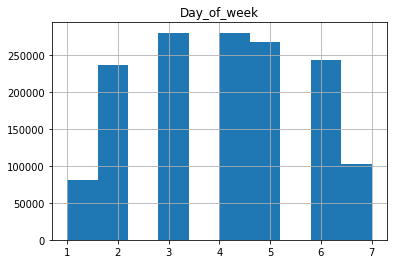

In [20]:
complaints_by_dayofweek = df.select('Day_of_week').toPandas()
complaints_by_dayofweek.hist();

In [21]:
complaints_by_products = df.groupBy('Product').count().orderBy('count', ascending=False).toPandas()
complaints_by_products.head(20)

,Product,count
0,"Credit reporting, credit repair services, or o...",331635
1,Mortgage,295097
2,Debt collection,278961
3,Credit reporting,139825
4,Credit card,89175
5,Bank account or service,86193
6,Credit card or prepaid card,67849
7,Checking or savings account,57461
8,Student loan,56365
9,Consumer Loan,31592


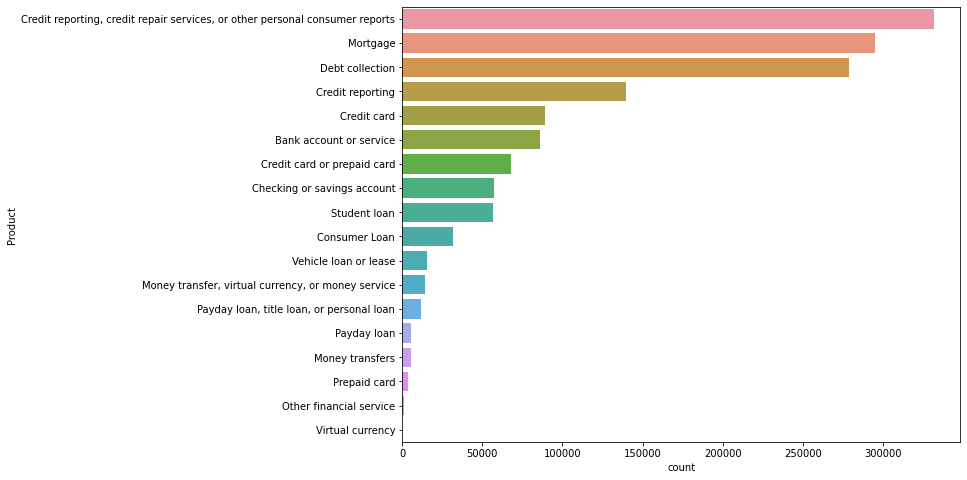

In [22]:
plt.figure(figsize=(10,8))
sb.barplot(data=complaints_by_products.head(20), x='count', y='Product')
plt.show()